In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow import Tensor
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:
training = pd.read_csv('D:/Kaggle/kagglex-cohort4/train.csv')
testing = pd.read_csv('D:/Kaggle/kagglex-cohort4/test.csv')
training = training[training['price'] < 174000]
training = training[training['model_year'] > 1990]
training = training[training['milage'] < 218000]

print(len(training['price']))
training.reset_index(drop=True, inplace=True)

52870


In [3]:
print(np.std(testing['milage']))
print(np.median(testing['milage']))
print(np.median(testing['milage']) + 3*np.std(testing['milage']))
print(np.median(testing['milage']) - 2*np.std(testing['milage']))

50714.26743488971
65680.0
217822.80230466914
-35748.534869779425


In [4]:
print(np.std(training['milage']))
print(np.median(training['milage']))
print(np.median(training['milage']) + 3*np.std(training['milage']))
print(np.median(training['milage']) - 2*np.std(training['milage']))

47404.637698042134
66250.0
208463.9130941264
-28559.275396084267


In [5]:
#print(training.dtypes)
print(training["model_year"].head)
count = 0
for i in training['model_year']:
    if i > 2024:
        count+=1
        print(i)
print(count)

<bound method NDFrame.head of 0        2018
1        2007
2        2009
3        2022
4        2001
         ... 
52865    2020
52866    2017
52867    2015
52868    2013
52869    2021
Name: model_year, Length: 52870, dtype: int64>
0


In [6]:
HPPL = []
count = 0
for i in range(len(training['engine'])):
        try:
            if "HP" in training['engine'][i] and "L" in training['engine'][i]: #gas engine
                split = training['engine'][i].split("HP")
                temp = float(split[0])
                split = split[1][1:].split("L")
                temp /= float(split[0])
                HPPL.append(temp)
                #print(f'Temp: {temp}')
            elif "HP" in training['engine'][i]: #electric motor electric fuel system
                split = training['engine'][i].split("HP")
                HPPL.append(float(split[0]))
            elif "L" in training['engine'][i]: #only liters
                split = training['engine'][i].split("L")
                HPPL.append(float(split[0]))
            else:
                count+=1
                HPPL.append(0)
#                 print(training['engine'][i])
        except:
            HPPL.append(0)
            print(training['engine'][i])
print(count)
print(len(HPPL))
HPPL = np.array(HPPL)

Intercooled Turbo Diesel V-8 6.7 L/406
Intercooled Turbo Diesel V-8 6.7 L/406
Intercooled Turbo Diesel V-8 6.7 L/406
354
52870


In [7]:
# Get unique values of column 'col1'
unique_values = training['accident'].unique()
print(len(unique_values))
# Print the unique values
print("Unique values in column 'col1':", unique_values)
# 4 cars are labeled not supported, can be pruned

2
Unique values in column 'col1': ['None reported' 'At least 1 accident or damage reported']


In [8]:
# id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
# brand (53), model (1827), model_year (continuous), milage (continuous), fuel_type (7), engine (1061), transmission (46), accident (3), price (continuous)
scaler = MinMaxScaler(feature_range=(0, 1))  # Set range to 0-1 for normalization

brand_factorized, brand_labels = training['brand'].factorize()
print(f'brand factorized: {max(brand_factorized)}')

# print(brand_factorized.shape)

model_factorized, model_labels = training['model'].factorize()
print(f'model factorized: {max(model_factorized)}')
# print(model_factorized.shape)

fuel_factorized, fuel_labels = training['fuel_type'].factorize()
print(f'fuel_factorized: {max(fuel_factorized)}')
# print(fuel_factorized.shape)

engine_factorized, engine_labels = training['engine'].factorize()
print(f'engine factorized: {max(engine_factorized)}')
# print(engine_factorized.shape)

transmission_factorized, transmission_label = training['transmission'].factorize()
print(f'transmission factorized: {max(transmission_factorized)}')
# print(transmission_factorized.shape)

accident_factorized, accident_label = training['accident'].factorize()
print(f'accident factorized: {max(accident_factorized)}')
# print(accident_factorized.shape)


model_year = np.array(training['model_year'])
array2024 = np.full(model_year.shape[0], 2024)
model_year = np.subtract(array2024, model_year)
#model_year = scaler.fit_transform(model_year.reshape(-1, 1)).squeeze()

mileage = np.array(training['milage'])
mileage = scaler.fit_transform(mileage.reshape(-1, 1)).squeeze()  # Reshape for scaler
print(max(mileage))
HPPL = scaler.fit_transform(HPPL.reshape(-1, 1)).squeeze()
price = training['price']


brand factorized: 51
model factorized: 1814
fuel_factorized: 5
engine factorized: 1055
transmission factorized: 45
accident factorized: 1
1.0


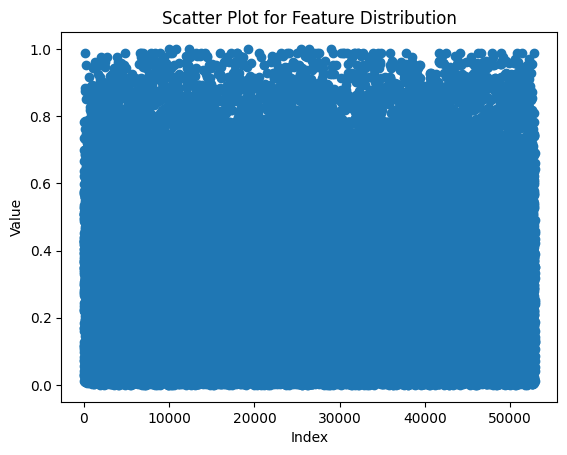

In [9]:
# brand (53), model (1827), model_year (continuous), milage (continuous), fuel_type (7), engine (1061), transmission (46), accident (2), price (continuous)

plt.scatter(range(len(mileage)), mileage)
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Scatter Plot for Feature Distribution")
plt.show()

In [21]:
# brand (53), model (1827), model_year (continuous), milage (continuous), fuel_type (7), engine (1061), transmission (46), accident (3), price (continuous)
x_train = []
y_train = []

for i in range(len(training['id'])):
    #temp = [brand_factorized[i], model_factorized[i], model_year[i], mileage[i], fuel_factorized[i], engine_factorized[i], transmission_factorized[i], accident_factorized[i]]
    #temp = [model_factorized[i], model_year[i], mileage[i], fuel_factorized[i], HPPL[i], transmission_factorized[i], accident_factorized[i]]
    temp = [brand_factorized[i], model_factorized[i], model_year[i], mileage[i], fuel_factorized[i], HPPL[i], transmission_factorized[i], accident_factorized[i]]
    #temp = [brand_factorized[i], mileage[i], fuel_factorized[i], HPPL[i], transmission_factorized[i], accident_factorized[i]]
    x_train.append(np.array([temp]))
    y_train.append(np.array([price[i]]))
x_train = np.array(x_train)
y_train = np.array(y_train)
x = len(x_train) == len(training['id'])
print(f'Status: {x}; {len(x_train)} total elements')
print(x_train[0])
print(x_train.shape)
print(y_train[0])
print(y_train.shape)

Status: True; 52870 total elements
[[0.         0.         6.         0.34153174 0.         0.10504202
  0.         0.        ]]
(52870, 1, 8)
[11000]
(52870, 1)


In [73]:
def build_model():
    model = keras.Sequential([
        keras.Input(shape=(1, 8)),
        layers.Dense(26, activation='silu', kernel_regularizer=l1(0.001)),
        layers.BatchNormalization(),
        layers.Dense(12, activation='silu'),
        layers.BatchNormalization(),
        layers.Dense(6, activation='silu'),
        layers.Dense(1),
    ])
    return model

batch_size = 100
model = tf.keras.models.load_model('model3.h5')
#model = build_model()
model.compile(loss="mean_squared_error", optimizer = 'adagrad', metrics=["mean_squared_error"])
model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = 10,
    validation_split = 0.25)
model.save('model4.h5')
print("model saved")

Epoch 1/10
397/397 [==============================] - 2s 5ms/step - loss: 390875008.0000 - mean_squared_error: 390875008.0000 - val_loss: 382971520.0000 - val_mean_squared_error: 382971520.0000
Epoch 2/10
397/397 [==============================] - 2s 4ms/step - loss: 387902368.0000 - mean_squared_error: 387902368.0000 - val_loss: 383599776.0000 - val_mean_squared_error: 383599776.0000
Epoch 3/10
397/397 [==============================] - 2s 4ms/step - loss: 387141568.0000 - mean_squared_error: 387141568.0000 - val_loss: 377044768.0000 - val_mean_squared_error: 377044768.0000
Epoch 4/10
397/397 [==============================] - 2s 4ms/step - loss: 385846336.0000 - mean_squared_error: 385846336.0000 - val_loss: 378727232.0000 - val_mean_squared_error: 378727232.0000
Epoch 5/10
397/397 [==============================] - 2s 4ms/step - loss: 384570464.0000 - mean_squared_error: 384570464.0000 - val_loss: 374262816.0000 - val_mean_squared_error: 374262816.0000
Epoch 6/10
397/397 [==========

In [51]:
model = build_model()
model.compile(loss="MeanSquaredLogarithmicError", optimizer = 'rmsprop', metrics=["mean_squared_error"])

for i in range(2):

    k = 4  # For example, using 5-fold cross-validation

    # Create a KFold object
    kf = KFold(n_splits=k, shuffle=True)

    # Loop through each fold
    for fold, (train_index, val_index) in enumerate(kf.split(x_test)):
        print(f"Training fold {fold + 1}")
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        model_checkpoint = ModelCheckpoint(filepath = f'model_{fold}.h5', monitor='val_loss')
        print("training begin")
        # Train the model on this fold
        history = model.fit(
            x=x_train_fold,
            y=y_train_fold,
            epochs=20,
            batch_size=100,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[model_checkpoint]
        )

Training fold 1
training begin
Epoch 1/20
272/272 [==============================] - 3s 7ms/step - loss: 86.1894 - mean_squared_error: 1833539584.0000 - val_loss: 76.1832 - val_mean_squared_error: 1820379776.0000
Epoch 2/20
272/272 [==============================] - 1s 5ms/step - loss: 62.6630 - mean_squared_error: 1832969216.0000 - val_loss: 55.8247 - val_mean_squared_error: 1819564032.0000
Epoch 3/20
272/272 [==============================] - 1s 5ms/step - loss: 47.8426 - mean_squared_error: 1831749888.0000 - val_loss: 42.7322 - val_mean_squared_error: 1817867648.0000
Epoch 4/20
272/272 [==============================] - 1s 5ms/step - loss: 38.0437 - mean_squared_error: 1829593344.0000 - val_loss: 34.2411 - val_mean_squared_error: 1815138048.0000
Epoch 5/20
272/272 [==============================] - 1s 5ms/step - loss: 30.9856 - mean_squared_error: 1826217728.0000 - val_loss: 28.1580 - val_mean_squared_error: 1811113728.0000
Epoch 6/20
272/272 [==============================] - 1s 5m

In [75]:
print(x_train[2], y_train[2])
model = tf.keras.models.load_model('model4.h5')
for i in range(100):
    print(y_train[i])
    print(model.predict(np.expand_dims(x_train[i], axis=0)))

[[ 2.          2.         15.          0.42038178  0.          0.07002801
   2.          0.        ]] [15000]
[11000]
[[[33444.848]]]
[8250]
[[[8232.513]]]
[15000]
[[[14126.489]]]
[63500]
[[[46446.145]]]
[7850]
[[[5301.01]]]
[4995]
[[[10297.734]]]
[26500]
[[[13427.]]]
[25500]
[[[20952.838]]]
[13999]
[[[20205.273]]]
[6700]
[[[14564.639]]]
[124995]
[[[40927.15]]]
[49900]
[[[23568.307]]]
[40000]
[[[16345.151]]]
[28250]
[[[38460.973]]]
[23500]
[[[17870.717]]]
[36800]
[[[26164.77]]]
[138999]
[[[51132.086]]]
[66200]
[[[26998.879]]]
[31900]
[[[19095.607]]]
[26485]
[[[37095.566]]]
[33500]
[[[19816.82]]]
[9500]
[[[17225.918]]]
[36500]
[[[36554.58]]]
[31300]
[[[32140.895]]]
[65000]
[[[33955.062]]]
[89995]
[[[56343.65]]]
[17000]
[[[13716.128]]]
[12000]
[[[22209.477]]]
[51900]
[[[24975.504]]]
[16999]
[[[20572.104]]]
[50000]
[[[57969.39]]]
[71000]
[[[51854.777]]]
[14999]
[[[13322.269]]]
[36500]
[[[39652.01]]]
[103500]
[[[29668.707]]]
[10995]
[[[13403.775]]]
[24995]
[[[42309.535]]]
[55000]
[[[47248.

In [76]:
brand_mapping = {brand: index for index, brand in enumerate(brand_labels)}
testing['brand_factorized'] = testing['brand'].map(brand_mapping).fillna(-1).astype(int)

model_mapping = {brand: index for index, brand in enumerate(model_labels)}
testing['model_factorized'] = testing['model'].map(model_mapping).fillna(-1).astype(int)

fuel_mapping = {brand: index for index, brand in enumerate(fuel_labels)}
testing['fuel_factorized'] = testing['fuel_type'].map(fuel_mapping).fillna(-1).astype(int)

engine_mapping = {brand: index for index, brand in enumerate(engine_labels)}
testing['engine_factorized'] = testing['engine'].map(engine_mapping).fillna(-1).astype(int)

transmission_mapping = {brand: index for index, brand in enumerate(transmission_label)}
testing['transmission_factorized'] = testing['transmission'].map(transmission_mapping).fillna(-1).astype(int)

accident_mapping = {brand: index for index, brand in enumerate(accident_label)}
testing['accident_factorized'] = testing['accident'].map(accident_mapping).fillna(-1).astype(int)

scaler = MinMaxScaler(feature_range=(0, 1))  # Set range to 0-1 for normalization
test_HPPL = []
count = 0
for i in range(len(testing['engine'])):
        try:
            if "HP" in testing['engine'][i] and "L" in testing['engine'][i]: #gas engine
                split = testing['engine'][i].split("HP")
                temp = float(split[0])
                split = split[1][1:].split("L")
                temp /= float(split[0])
                test_HPPL.append(temp)
                #print(f'Temp: {temp}')
            elif "HP" in testing['engine'][i]: #electric motor electric fuel system
                split = testing['engine'][i].split("HP")
                test_HPPL.append(float(split[0]))
            elif "L" in testing['engine'][i]: #only liters
                split = testing['engine'][i].split("L")
                test_HPPL.append(float(split[0]))
            else:
                count+=1
                test_HPPL.append(0)
#                 print(training['engine'][i])
        except:
            test_HPPL.append(0)
            print(testing['engine'][i])
print(count)
print(len(test_HPPL))
test_HPPL = np.array(test_HPPL)

test_model_year = np.array(testing['model_year'])
array2024 = np.full(test_model_year.shape[0], 2024)
test_model_year = np.subtract(array2024, test_model_year)
#test_model_year = scaler.fit_transform(test_model_year.reshape(-1, 1)).squeeze()

test_mileage = np.array(testing['milage'])
test_mileage = scaler.fit_transform(test_mileage.reshape(-1, 1)).squeeze()  # Reshape for scaler
print(max(test_mileage))
test_HPPL = scaler.fit_transform(test_HPPL.reshape(-1, 1)).squeeze()

x_test = []
for i in range(len(testing['id'])):
    x_test.append([testing['brand_factorized'][i], testing['model_factorized'][i], test_model_year[i], test_mileage[i], testing['fuel_factorized'][i], test_HPPL[i], testing['transmission_factorized'][i], testing['accident_factorized'][i]])
    #x_test.append([testing['model_factorized'][i], test_model_year[i], test_mileage[i], testing['fuel_factorized'][i], test_HPPL[i], testing['transmission_factorized'][i], testing['accident_factorized'][i]])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], 1, 8))

Intercooled Turbo Premium Unleaded I-4 2.0 L/122
241
36183
1.0


In [77]:
id = []
prices = []
model = tf.keras.models.load_model('model4.h5')
print(x_test.shape)
for i in range(len(testing['id'])):
    id.append(testing['id'][i])
    prices.append(model.predict(np.expand_dims(x_test[i], axis=0)))
    if i%1000 == 0:
        print(i)
data = {"id": id, "price": prices}
df = pd.DataFrame(data)
df.to_csv("submission.csv", index=False)
print(f"CSV file created with {len(df)} entries!")

(36183, 1, 8)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
CSV file created with 36183 entries!


In [78]:
id = np.array(id)
prices = np.array(prices)

In [80]:
prices = np.reshape(prices, (36183))
data = {"id": id, "price": prices}
df = pd.DataFrame(data)
df.to_csv("submission.csv", index=False)
print(f"CSV file created with {len(df)} entries!")

CSV file created with 36183 entries!
